# 01 - Data Exploration

Comprehensive exploration of the DT Mart Market Mix Modeling dataset.

## Dataset Files Overview

| File | Description | Rows | Date Range |
|------|-------------|------|------------|
| `Sales.csv` | Raw transaction-level data (tab-separated) | ~1M | Jan 2015 – Dec 2016 |
| `firstfile.csv` | Daily aggregated by product vertical | ~1.6M | Jul 2015 – Jun 2016 |
| `Secondfile.csv` | Monthly aggregated with media spend & NPS | 12 | Jul 2015 – Jun 2016 |
| `MediaInvestment.csv` | Monthly media investment by channel | 12 | Jul 2015 – Jun 2016 |
| `MonthlyNPSscore.csv` | Monthly Net Promoter Score | 12 | Jul 2015 – Jun 2016 |
| `SpecialSale.csv` | Special sale event dates | 44 | Jul 2015 – May 2016 |
| `ProductList.csv` | Product category frequency | 75 | N/A |

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)
%matplotlib inline

from mmm_test.data import download_dataset

data_dir = download_dataset()
print(f"Data directory: {data_dir}")
print(f"Files: {sorted([f.name for f in data_dir.glob('*.csv')])}")

Data directory: data
Files: ['MediaInvestment.csv', 'MonthlyNPSscore.csv', 'ProductList.csv', 'Sales.csv', 'Secondfile.csv', 'SpecialSale.csv', 'firstfile.csv']


---
## 1. Sales.csv — Raw Transaction Data

The most granular file. Contains individual order items with timestamps, GMV, units, product hierarchy, and SLA info. Spans **Jan 2015 – Dec 2016** (24 months).

In [3]:
sales_raw = pd.read_csv(data_dir / "Sales.csv", sep="\t")
sales_raw["Date"] = pd.to_datetime(sales_raw["Date"], format="mixed")
print(f"Shape: {sales_raw.shape}")
print(f"Date range: {sales_raw['Date'].min()} to {sales_raw['Date'].max()}")
print(f"Unique dates: {sales_raw['Date'].dt.date.nunique()}")
print(f"\nColumns: {sales_raw.columns.tolist()}")
sales_raw.head()

Shape: (1048575, 13)
Date range: 2015-01-10 00:00:00 to 2016-12-05 17:29:00
Unique dates: 250

Columns: ['ID', 'Date', 'ID_Order', 'ID_Item_ordered', 'GMV', 'Units_sold', 'SLA', 'Product_Category', 'Analytic_Category', 'Sub_category', 'product_analytic_vertical', 'MRP', 'Procurement_SLA']


,ID,Date,ID_Order,ID_Item_ordered,GMV,Units_sold,SLA,Product_Category,Analytic_Category,Sub_category,product_analytic_vertical,MRP,Procurement_SLA
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:00,3.420000e+15,3.420000e+15,6400,1,5,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:00,1.420000e+15,1.420000e+15,6900,1,7,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:00,2.420000e+15,2.420000e+15,1990,1,10,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:00,4.420000e+15,4.420000e+15,1690,1,4,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:00,4.420000e+15,4.420000e+15,1618,1,6,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [4]:
sales_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 13 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   ID                         1048575 non-null  str           
 1   Date                       1048575 non-null  datetime64[us]
 2   ID_Order                   1048575 non-null  float64       
 3   ID_Item_ordered            1048575 non-null  float64       
 4   GMV                        1048575 non-null  object        
 5   Units_sold                 1048575 non-null  int64         
 6   SLA                        1048575 non-null  int64         
 7   Product_Category           1048575 non-null  str           
 8   Analytic_Category          1048575 non-null  str           
 9   Sub_category               1048575 non-null  str           
 10  product_analytic_vertical  1048575 non-null  str           
 11  MRP                        1048575 non-null  int

In [5]:
# Product hierarchy
print("Product Categories:")
print(sales_raw["Product_Category"].value_counts())
print(f"\nAnalytic Categories: {sales_raw['Analytic_Category'].nunique()}")
print(sales_raw["Analytic_Category"].value_counts())
print(f"\nSub-categories: {sales_raw['Sub_category'].nunique()}")
print(sales_raw["Sub_category"].value_counts().head(15))

Product Categories:
Product_Category
CE    1048575
Name: count, dtype: int64

Analytic Categories: 5
Analytic_Category
EntertainmentSmall    601384
CameraAccessory       160572
GamingHardware        145762
Camera                 72577
GameCDDVD              68280
Name: count, dtype: int64

Sub-categories: 14
Sub_category
Speaker                362022
CameraAccessory        149270
GamingAccessory        130782
HomeAudio               82111
AudioMP3Player          73204
TVVideoSmall            73022
Camera                  72577
Game                    68264
GamingConsole           14980
CameraStorage           11302
AudioAccessory           6160
HomeTheatre              2763
AmplifierReceiver        2102
GameMembershipCards        16
Name: count, dtype: int64


In [6]:
# Monthly transaction volume and GMV from Sales.csv
sales_raw["GMV"] = pd.to_numeric(sales_raw["GMV"], errors="coerce")
sales_monthly = (
    sales_raw.groupby(sales_raw["Date"].dt.to_period("M"))
    .agg(
        transactions=("ID", "count"),
        total_gmv=("GMV", "sum"),
        total_units=("Units_sold", "sum"),
        avg_gmv=("GMV", "mean"),
        avg_mrp=("MRP", "mean"),
    )
    .reset_index()
)
sales_monthly["Date"] = sales_monthly["Date"].dt.to_timestamp()

print(f"Monthly aggregation from Sales.csv ({len(sales_monthly)} months):")
sales_monthly

Monthly aggregation from Sales.csv (24 months):


,Date,transactions,total_gmv,total_units,avg_gmv,avg_mrp
0,2015-01-01,16809,2.417202e+07,17211,1444.226325,2326.748052
1,2015-02-01,13785,2.475064e+07,14263,1804.113937,2909.384984
2,2015-03-01,11304,2.489587e+07,11657,2211.393702,3473.256281
3,2015-04-01,11704,2.454374e+07,12057,2108.750316,3414.373889
4,2015-05-01,10671,2.372625e+07,10983,2235.584061,3549.602849
5,2015-06-01,11006,2.374245e+07,11267,2167.864637,3473.103580
6,2015-07-01,18521,7.535963e+07,19183,4088.078076,6906.995087
7,2015-08-01,17207,6.005747e+07,17645,3507.210158,6014.632359
8,2015-09-01,16115,6.731766e+07,16469,4195.292292,7111.210797
9,2015-10-01,183544,4.612227e+08,187602,2531.297811,4656.603626


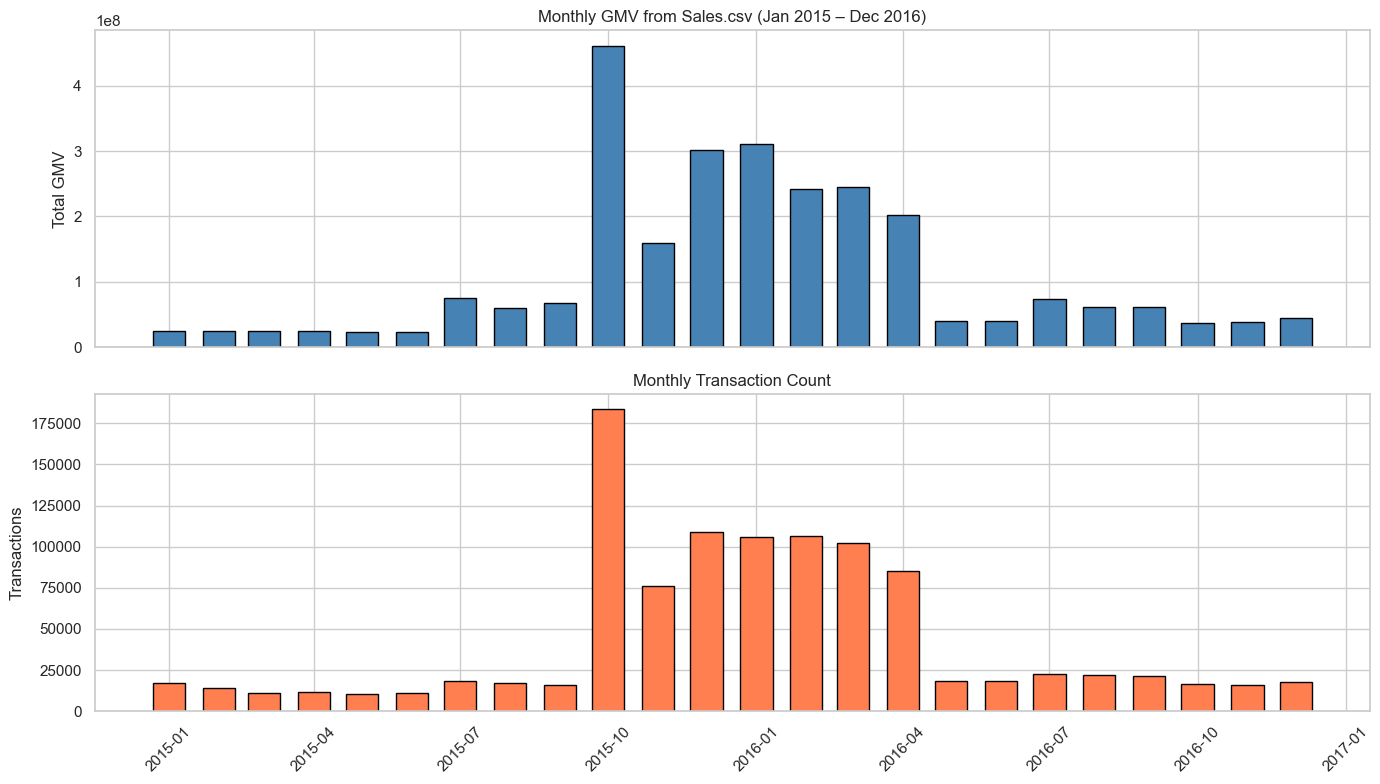

In [7]:
# Sales.csv monthly GMV over time — full 24-month view
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].bar(
    sales_monthly["Date"],
    sales_monthly["total_gmv"],
    width=20,
    color="steelblue",
    edgecolor="black",
)
axes[0].set_title("Monthly GMV from Sales.csv (Jan 2015 – Dec 2016)")
axes[0].set_ylabel("Total GMV")

axes[1].bar(
    sales_monthly["Date"],
    sales_monthly["transactions"],
    width=20,
    color="coral",
    edgecolor="black",
)
axes[1].set_title("Monthly Transaction Count")
axes[1].set_ylabel("Transactions")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

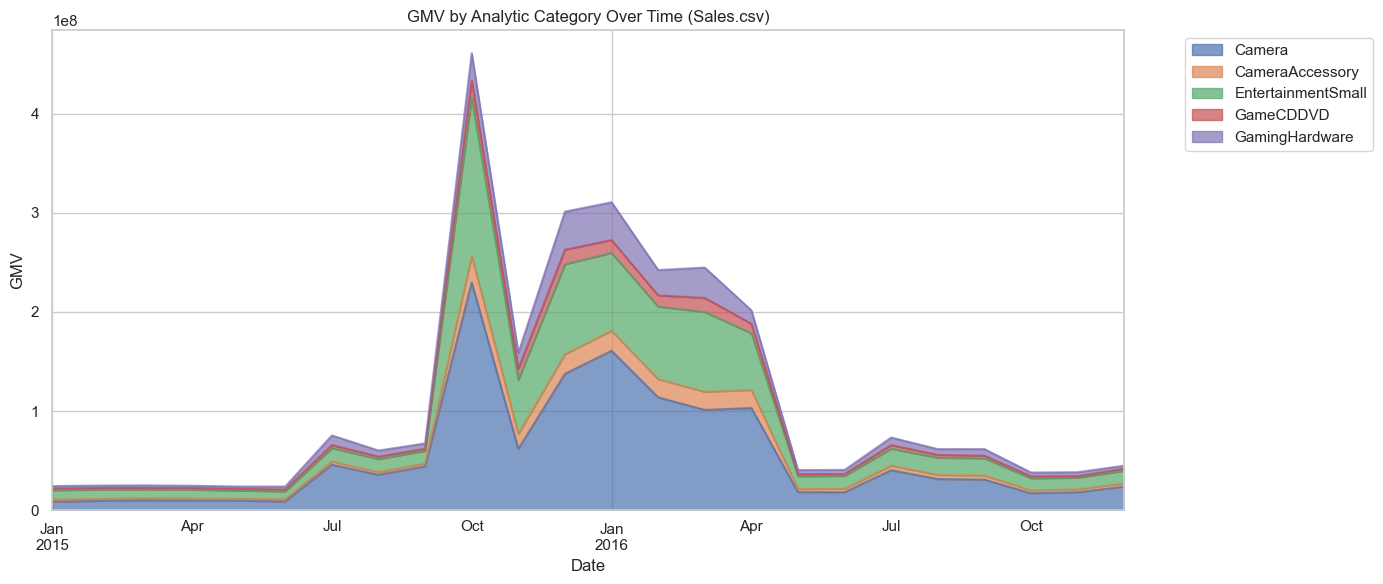

In [8]:
# GMV by product category over time
cat_monthly = (
    sales_raw.groupby([sales_raw["Date"].dt.to_period("M"), "Analytic_Category"])["GMV"]
    .sum()
    .unstack(fill_value=0)
)
cat_monthly.index = cat_monthly.index.to_timestamp()

fig, ax = plt.subplots(figsize=(14, 6))
cat_monthly.plot.area(ax=ax, alpha=0.7)
ax.set_title("GMV by Analytic Category Over Time (Sales.csv)")
ax.set_ylabel("GMV")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

---
## 2. firstfile.csv — Daily Aggregated Data

Daily-level aggregation by product vertical with GMV, units, MRP, discount, and sale event flags. Spans **Jul 2015 – Jun 2016**.

In [9]:
daily = pd.read_csv(data_dir / "firstfile.csv")
daily = daily.drop(columns=["Unnamed: 0"], errors="ignore")
daily["Date"] = pd.to_datetime(daily["Date"])
print(f"Shape: {daily.shape}")
print(f"Date range: {daily['Date'].min()} to {daily['Date'].max()}")
print(f"Unique dates: {daily['Date'].nunique()}")
print(f"\nColumns: {daily.columns.tolist()}")
daily.head()

Shape: (1578079, 9)
Date range: 2015-07-01 00:00:00 to 2016-06-30 00:00:00
Unique dates: 360

Columns: ['Date', 'Sales_name', 'gmv_new', 'units', 'product_mrp', 'discount', 'product_category', 'product_subcategory', 'product_vertical']


,Date,Sales_name,gmv_new,units,product_mrp,discount,product_category,product_subcategory,product_vertical
0,2015-07-01,No Promotion,3040.0,1,3650.0,610.0,EntertainmentSmall,HomeAudio,HomeAudioSpeaker
1,2015-07-01,No Promotion,310.0,1,400.0,90.0,EntertainmentSmall,Speaker,LaptopSpeaker
2,2015-07-01,No Promotion,1999.0,1,7999.0,6000.0,GamingHardware,GamingAccessory,GamePad
3,2015-07-01,No Promotion,139.0,1,700.0,561.0,EntertainmentSmall,TVVideoSmall,RemoteControl
4,2015-07-01,No Promotion,99.0,1,700.0,601.0,EntertainmentSmall,TVVideoSmall,RemoteControl


In [10]:
# Product breakdown in firstfile
print("Product categories:")
print(daily["product_category"].value_counts())
print(f"\nSubcategories: {daily['product_subcategory'].nunique()}")
print(daily["product_subcategory"].value_counts())
print(f"\nVerticals: {daily['product_vertical'].nunique()}")

Product categories:
product_category
EntertainmentSmall    918775
CameraAccessory       246499
GamingHardware        222773
Camera                 99301
GameCDDVD              90731
Name: count, dtype: int64

Subcategories: 14
product_subcategory
Speaker                530991
CameraAccessory        228845
GamingAccessory        195216
TVVideoSmall           140329
HomeAudio              118103
AudioMP3Player         110949
Camera                  99301
Game                    90634
GamingConsole           27557
CameraStorage           17654
AudioAccessory          10267
HomeTheatre              4132
AmplifierReceiver        4004
GameMembershipCards        97
Name: count, dtype: int64

Verticals: 72


In [11]:
# Sale events in firstfile
print("Sales event flags (Sales_name):")
print(daily["Sales_name"].value_counts())

Sales event flags (Sales_name):
Sales_name
No Promotion                 1291840
Daussera sale                  93417
Christmas & New Year Sale      42501
Big Diwali Sale                42365
Pacman                         25555
BSD-5                          25537
Republic Day                   22762
FHSD                           11792
Valentine's Day                 8074
BED                             7832
Eid & Rathayatra sale           6384
Rakshabandhan Sale                15
Independence Sale                  5
Name: count, dtype: int64


In [12]:
# Aggregate daily data to monthly for comparison
daily_monthly = (
    daily.groupby(daily["Date"].dt.to_period("M"))
    .agg(
        total_gmv=("gmv_new", "sum"),
        total_units=("units", "sum"),
        total_mrp=("product_mrp", "sum"),
        total_discount=("discount", "sum"),
        records=("gmv_new", "count"),
    )
    .reset_index()
)
daily_monthly["Date"] = daily_monthly["Date"].dt.to_timestamp()

print("Monthly aggregation from firstfile.csv:")
daily_monthly

Monthly aggregation from firstfile.csv:


,Date,total_gmv,total_units,total_mrp,total_discount,records
0,2015-07-01,1.657196e+08,85606,287933574.0,1.222140e+08,83474
1,2015-08-01,4.017390e+05,258,649522.0,2.477830e+05,254
2,2015-09-01,3.966427e+08,200239,671180250.0,2.745376e+08,195781
3,2015-10-01,4.887094e+08,204001,913836074.0,4.251267e+08,199541
4,2015-11-01,3.172484e+08,127035,532173296.0,2.149249e+08,124036
5,2015-12-01,4.238140e+08,157201,737220553.0,3.134065e+08,152782
6,2016-01-01,3.778607e+08,141937,672018470.0,2.941577e+08,138924
7,2016-02-01,3.214803e+08,141998,560857425.0,2.393771e+08,139273
8,2016-03-01,3.890068e+08,150845,676662921.0,2.876561e+08,147745
9,2016-04-01,3.223023e+08,131078,535544811.0,2.132425e+08,128773


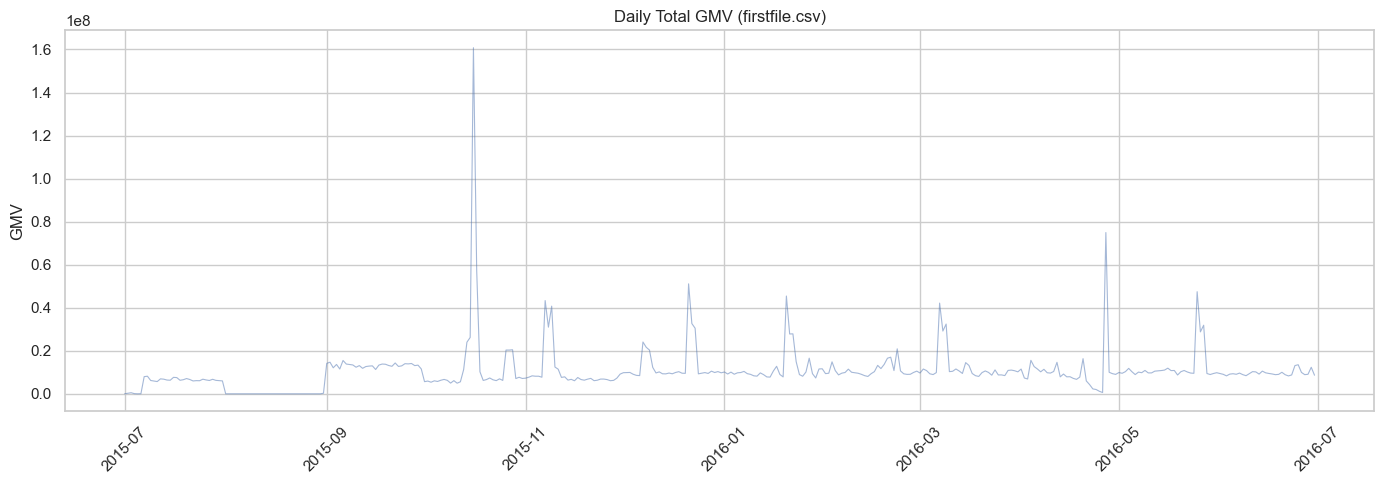

In [13]:
# Daily total GMV time series
daily_total = daily.groupby("Date")["gmv_new"].sum().reset_index()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(daily_total["Date"], daily_total["gmv_new"], alpha=0.5, linewidth=0.8)
ax.set_title("Daily Total GMV (firstfile.csv)")
ax.set_ylabel("GMV")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

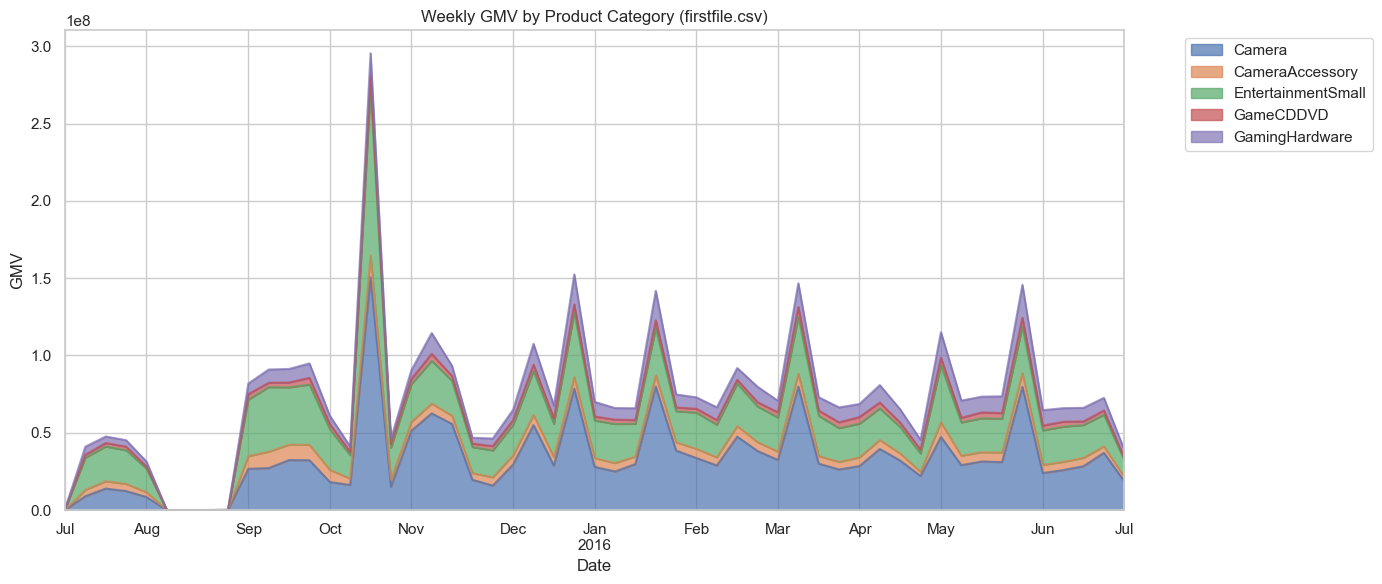

In [14]:
# Daily GMV by product category
daily_cat = (
    daily.groupby(["Date", "product_category"])["gmv_new"].sum().unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(14, 6))
daily_cat.resample("W").sum().plot.area(ax=ax, alpha=0.7)
ax.set_title("Weekly GMV by Product Category (firstfile.csv)")
ax.set_ylabel("GMV")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

---
## 3. Secondfile.csv — Monthly Aggregated (MMM-Ready)

Pre-aggregated monthly data combining revenue, units, MRP, discounts per product category with media investment and NPS. This is the file `firstfile.csv` was aggregated into, with media spend and NPS joined. Spans **Jul 2015 – Jun 2016** (12 months).

In [15]:
df = pd.read_csv(data_dir / "Secondfile.csv")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print(f"Shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Months: {len(df)}")
df.head()

Shape: (12, 39)
Date range: 2015-07-01 00:00:00 to 2016-06-01 00:00:00
Months: 12


,month,Revenue_Camera,Revenue_CameraAccessory,Revenue_EntertainmentSmall,Revenue_GameCDDVD,Revenue_GamingHardware,total_gmv,Units_Camera,Units_CameraAccessory,Units_EntertainmentSmall,Units_GameCDDVD,Units_GamingHardware,total_Units,Mrp_Camera,Mrp_CameraAccessory,Mrp_EntertainmentSmall,Mrp_GameCDDVD,Mrp_GamingHardware,total_Mrp,Discount_Camera,Discount_CameraAccessory,Discount_EntertainmentSmall,Discount_GameCDDVD,Discount_GamingHardware,total_Discount,Year,Month,Total.Investment,TV,Digital,Sponsorship,Content.Marketing,Online.marketing,Affiliates,SEM,Radio,Other,Date,NPS
0,Jul 2015,4.614023e+07,1.755561e+07,8.463275e+07,1.075666e+07,1.785191e+07,1.769372e+08,3519,12996,56804,5474,12145,90938,58325275,30857187,158627169,15242286,35750761,298802678,1.218505e+07,1.330158e+07,7.399442e+07,4.485621e+06,1.789885e+07,1.218655e+08,2015,7,1.710000e+08,2000000.0,25000000.0,74000000.0,0.0,13000000.0,5000000.0,50000000.0,NaN,NaN,2015-07-01,54.6
1,Aug 2015,6.155000e+04,4.227800e+04,2.586660e+05,1.805400e+04,3.864800e+04,4.191960e+05,4,38,175,8,50,275,84880,60305,419317,26994,74910,666406,2.333000e+04,1.802700e+04,1.606510e+05,8.940000e+03,3.626200e+04,2.472100e+05,2015,8,5.100000e+07,0.0,13000000.0,11000000.0,0.0,1000000.0,1000000.0,25000000.0,NaN,NaN,2015-08-01,60.0
2,Sep 2015,1.370821e+08,4.620538e+07,1.783461e+08,2.477973e+07,4.007520e+07,4.264885e+08,9348,36051,127340,13201,28068,214008,177590293,86501041,326376783,34128867,75560625,700157609,4.050820e+07,4.029566e+07,1.480306e+08,9.349133e+06,3.548543e+07,2.736691e+08,2015,9,9.630000e+08,39000000.0,14000000.0,628000000.0,6000000.0,164000000.0,50000000.0,62000000.0,NaN,NaN,2015-09-01,46.9
3,Oct 2015,2.427325e+08,3.216185e+07,1.817664e+08,2.109576e+07,3.177574e+07,5.095323e+08,15726,27088,133872,11070,24183,211939,391082399,60652149,356901008,31430731,92985886,933052173,1.483499e+08,2.849030e+07,1.751346e+08,1.033497e+07,6.121014e+07,4.235199e+08,2015,10,1.702000e+09,61000000.0,126000000.0,847000000.0,34000000.0,244000000.0,70000000.0,319000000.0,NaN,NaN,2015-10-01,44.4
4,Nov 2015,1.635928e+08,2.373963e+07,9.420911e+07,1.931035e+07,3.363579e+07,3.344877e+08,8972,18727,78711,8717,18218,133345,247906583,43937246,175775224,25591014,55682087,548892154,8.431378e+07,2.019762e+07,8.156611e+07,6.280660e+06,2.204630e+07,2.144045e+08,2015,11,5.120000e+08,42000000.0,13000000.0,142000000.0,2000000.0,196000000.0,66000000.0,52000000.0,NaN,NaN,2015-11-01,47.0


In [16]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   month                        12 non-null     str           
 1   Revenue_Camera               12 non-null     float64       
 2   Revenue_CameraAccessory      12 non-null     float64       
 3   Revenue_EntertainmentSmall   12 non-null     float64       
 4   Revenue_GameCDDVD            12 non-null     float64       
 5   Revenue_GamingHardware       12 non-null     float64       
 6   total_gmv                    12 non-null     float64       
 7   Units_Camera                 12 non-null     int64         
 8   Units_CameraAccessory        12 non-null     int64         
 9   Units_EntertainmentSmall     12 non-null     int64         
 10  Units_GameCDDVD              12 non-null     int64         
 11  Units_GamingHardware         12 non-null     int64        

In [17]:
# Identify column groups
revenue_cols = [c for c in df.columns if c.startswith("Revenue_")]
units_cols = [c for c in df.columns if c.startswith("Units_")]
mrp_cols = [c for c in df.columns if c.startswith("Mrp_")]
discount_cols = [c for c in df.columns if c.startswith("Discount_")]
media_cols = [
    "TV",
    "Digital",
    "Sponsorship",
    "Content.Marketing",
    "Online.marketing",
    "Affiliates",
    "SEM",
    "Radio",
    "Other",
]

print(f"Revenue columns ({len(revenue_cols)}): {revenue_cols}")
print(f"Units columns ({len(units_cols)}): {units_cols}")
print(f"MRP columns ({len(mrp_cols)}): {mrp_cols}")
print(f"Discount columns ({len(discount_cols)}): {discount_cols}")
print(f"Media channels ({len(media_cols)}): {media_cols}")
print("Totals: total_gmv, total_Units, total_Mrp, total_Discount, Total.Investment")
print("Other: Date, month, Year, Month, NPS")

Revenue columns (5): ['Revenue_Camera', 'Revenue_CameraAccessory', 'Revenue_EntertainmentSmall', 'Revenue_GameCDDVD', 'Revenue_GamingHardware']
Units columns (5): ['Units_Camera', 'Units_CameraAccessory', 'Units_EntertainmentSmall', 'Units_GameCDDVD', 'Units_GamingHardware']
MRP columns (5): ['Mrp_Camera', 'Mrp_CameraAccessory', 'Mrp_EntertainmentSmall', 'Mrp_GameCDDVD', 'Mrp_GamingHardware']
Discount columns (5): ['Discount_Camera', 'Discount_CameraAccessory', 'Discount_EntertainmentSmall', 'Discount_GameCDDVD', 'Discount_GamingHardware']
Media channels (9): ['TV', 'Digital', 'Sponsorship', 'Content.Marketing', 'Online.marketing', 'Affiliates', 'SEM', 'Radio', 'Other']
Totals: total_gmv, total_Units, total_Mrp, total_Discount, Total.Investment
Other: Date, month, Year, Month, NPS


In [ ]:
df.describe()

---
## 4. MediaInvestment.csv — Channel Spend Detail

Monthly media investment broken down by 9 channels. Values appear to be in Crores (10M INR). Spans **Jul 2015 – Jun 2016**.

In [18]:
media = pd.read_csv(data_dir / "MediaInvestment.csv")
print(f"Shape: {media.shape}")
print(f"\nColumns: {media.columns.tolist()}")
media

Shape: (12, 12)

Columns: ['Year', 'Month', 'Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other']


,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015,7,17.1,0.2,2.5,7.4,0.0,1.3,0.5,5.0,NaN,NaN
1,2015,8,5.1,0.0,1.3,1.1,0.0,0.1,0.1,2.5,NaN,NaN
2,2015,9,96.3,3.9,1.4,62.8,0.6,16.4,5.0,6.2,NaN,NaN
3,2015,10,170.2,6.1,12.6,84.7,3.4,24.4,7.0,31.9,NaN,NaN
4,2015,11,51.2,4.2,1.3,14.2,0.2,19.6,6.6,5.2,NaN,NaN
5,2015,12,106.7,5.4,3.1,56.7,1.1,22.5,6.8,11.2,NaN,NaN
6,2016,1,74.2,4.4,0.5,4.2,0.9,22.9,7.4,4.2,2.7,27.1
7,2016,2,48.1,2.6,1.9,11.7,0.6,19.9,6.5,4.9,NaN,NaN
8,2016,3,100.0,9.3,2.1,41.6,0.4,18.4,6.2,5.2,0.9,15.9
9,2016,4,56.8,5.2,0.9,24.3,0.0,16.5,5.7,4.2,NaN,NaN


In [19]:
# Compare MediaInvestment with Secondfile media columns
# MediaInvestment appears to be in Crores, Secondfile in raw values
print("MediaInvestment.csv TV values (likely Crores):")
print(media["TV"].values)
print("\nSecondfile.csv TV values (raw):")
print(df["TV"].values)
print("\nRatio (Secondfile / MediaInvestment):")
ratio = df["TV"].values / media["TV"].replace(0, np.nan).values
print(ratio)

MediaInvestment.csv TV values (likely Crores):
[0.2 0.  3.9 6.1 4.2 5.4 4.4 2.6 9.3 5.2 1.4 1.7]

Secondfile.csv TV values (raw):
[ 2000000.        0. 39000000. 61000000. 42000000. 54000000. 44000000.
 26000000. 93000000. 52000000. 14000000. 17000000.]

Ratio (Secondfile / MediaInvestment):
[10000000.       nan 10000000. 10000000. 10000000. 10000000. 10000000.
 10000000. 10000000. 10000000. 10000000. 10000000.]


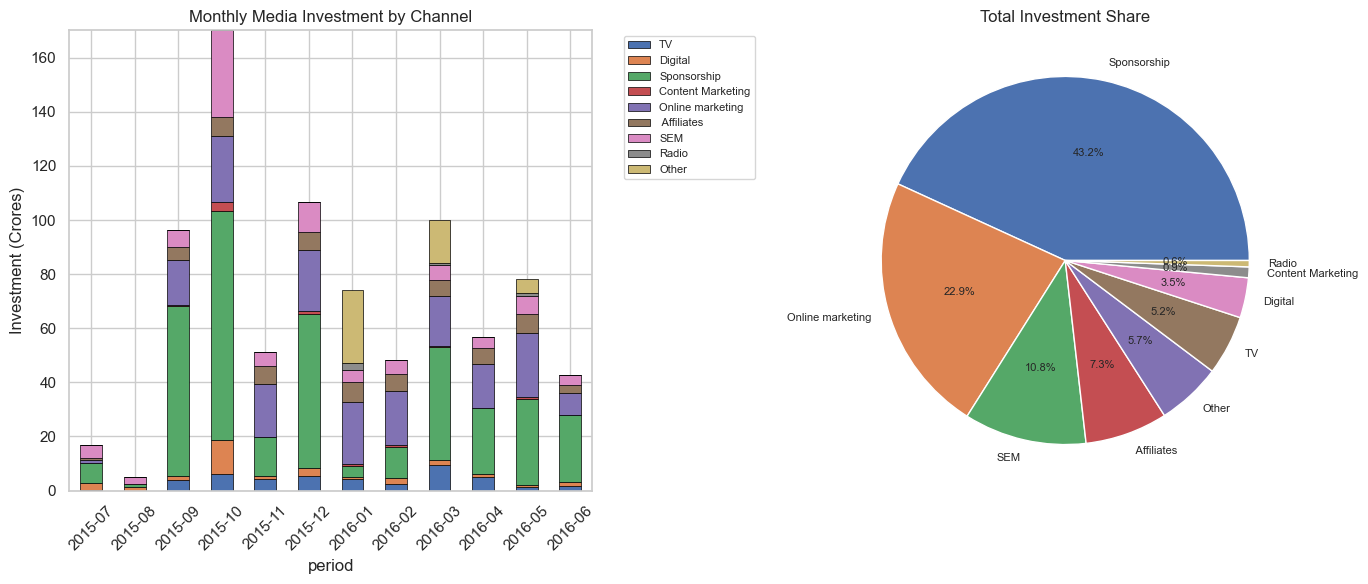

In [21]:
# Media spend breakdown
channel_cols_media = [
    "TV",
    "Digital",
    "Sponsorship",
    "Content Marketing",
    "Online marketing",
    " Affiliates",
    "SEM",
    "Radio",
    "Other",
]
available = [c for c in channel_cols_media if c in media.columns]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Stacked bar
media_plot = media.copy()
media_plot["period"] = (
    media_plot["Year"].astype(str) + "-" + media_plot["Month"].astype(str).str.zfill(2)
)
media_plot.set_index("period")[available].plot.bar(
    stacked=True, ax=axes[0], edgecolor="black", linewidth=0.5
)
axes[0].set_title("Monthly Media Investment by Channel")
axes[0].set_ylabel("Investment (Crores)")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

# Total share
totals = media[available].sum().sort_values(ascending=False)
totals = totals[totals > 0]
totals.plot.pie(ax=axes[1], autopct="%1.1f%%", fontsize=8)
axes[1].set_title("Total Investment Share")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

---
## 5. MonthlyNPSscore.csv — Customer Satisfaction

Net Promoter Score per month. Ranges from 44.4 to 60.0.

In [22]:
nps = pd.read_csv(data_dir / "MonthlyNPSscore.csv")
nps["Date"] = pd.to_datetime(nps["Date"])
nps = nps.sort_values("Date").reset_index(drop=True)
print(f"Shape: {nps.shape}")
print(f"Date range: {nps['Date'].min()} to {nps['Date'].max()}")
print(
    f"NPS range: {nps['NPS'].min()} to {nps['NPS'].max()} (mean: {nps['NPS'].mean():.1f})"
)
nps

Shape: (12, 2)
Date range: 2015-07-01 00:00:00 to 2016-06-01 00:00:00
NPS range: 44.4 to 60.0 (mean: 49.6)


,Date,NPS
0,2015-07-01,54.6
1,2015-08-01,60.0
2,2015-09-01,46.9
3,2015-10-01,44.4
4,2015-11-01,47.0
5,2015-12-01,45.8
6,2016-01-01,47.1
7,2016-02-01,50.3
8,2016-03-01,49.0
9,2016-04-01,51.8


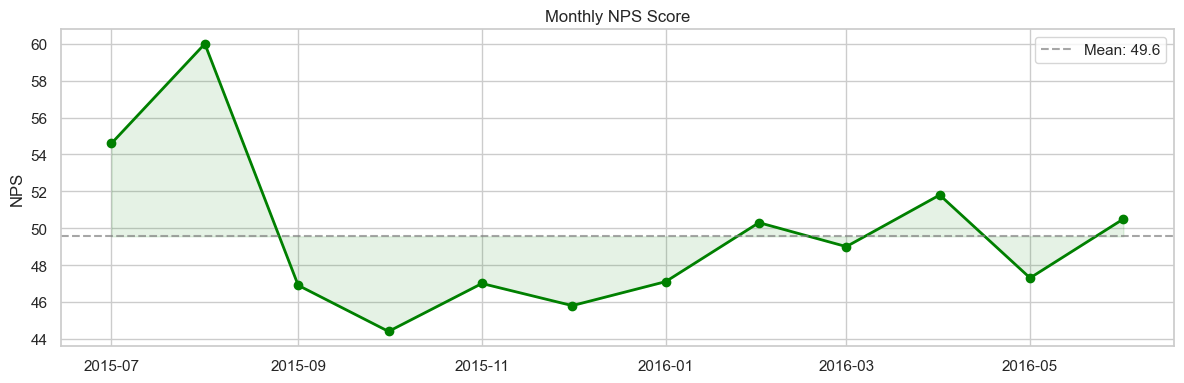

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(nps["Date"], nps["NPS"], marker="o", linewidth=2, color="green")
ax.axhline(
    y=nps["NPS"].mean(),
    color="gray",
    linestyle="--",
    alpha=0.7,
    label=f"Mean: {nps['NPS'].mean():.1f}",
)
ax.fill_between(nps["Date"], nps["NPS"], nps["NPS"].mean(), alpha=0.1, color="green")
ax.set_title("Monthly NPS Score")
ax.set_ylabel("NPS")
ax.legend()
plt.tight_layout()
plt.show()

---
## 6. SpecialSale.csv — Promotional Events

44 sale event days across 12 unique promotions. These are important control variables.

In [24]:
special_sales = pd.read_csv(data_dir / "SpecialSale.csv")
special_sales["Date"] = pd.to_datetime(special_sales["Date"])
print(f"Shape: {special_sales.shape}")
print(f"Date range: {special_sales['Date'].min()} to {special_sales['Date'].max()}")
print(f"\nSale events ({special_sales['Sales Name'].nunique()} unique):")
print(special_sales["Sales Name"].value_counts())
print("\nSale days per month:")
print(special_sales.groupby(special_sales["Date"].dt.to_period("M")).size())

Shape: (44, 2)
Date range: 2015-07-18 00:00:00 to 2016-05-27 00:00:00

Sale events (12 unique):
Sales Name
Christmas & New Year Sale    10
Big Diwali Sale               8
Independence Sale             3
Rakshabandhan Sale            3
Daussera sale                 3
Republic Day                  3
BSD-5                         3
Pacman                        3
Eid & Rathayatra sale         2
BED                           2
Valentine's Day               2
FHSD                          2
Name: count, dtype: int64

Sale days per month:
Date
2015-07    2
2015-08    6
2015-10    3
2015-11    8
2015-12    7
2016-01    6
2016-02    6
2016-03    3
2016-05    3
Freq: M, dtype: int64


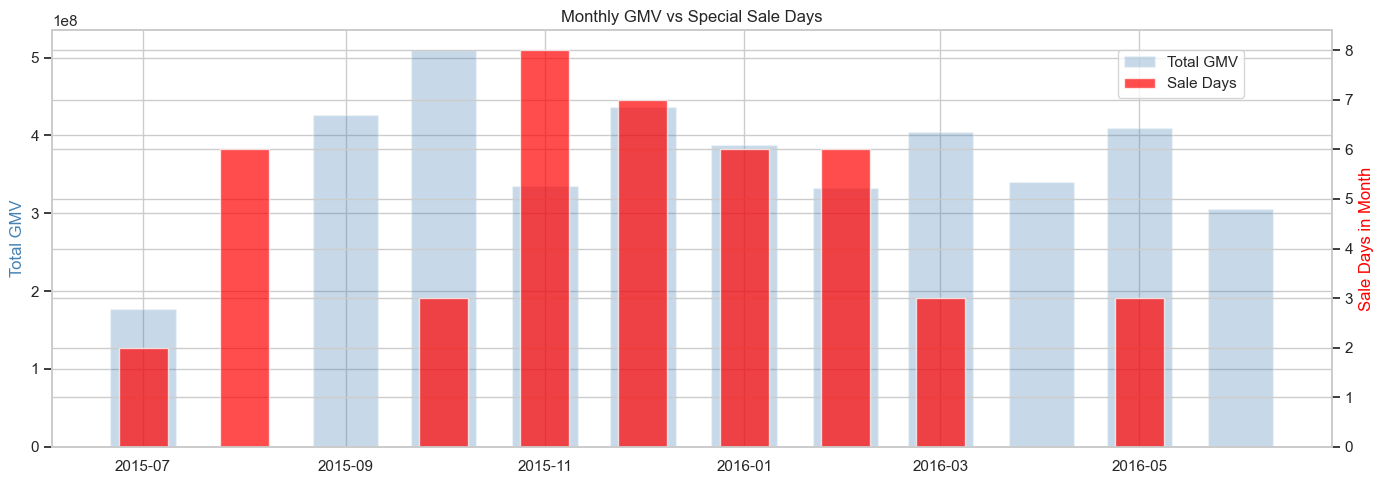

In [25]:
# Visualize sale events on a timeline with GMV
sale_days_monthly = (
    special_sales.groupby(special_sales["Date"].dt.to_period("M"))
    .size()
    .reset_index(name="sale_days")
)
sale_days_monthly["Date"] = sale_days_monthly["Date"].dt.to_timestamp()

fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.bar(
    df["Date"],
    df["total_gmv"],
    width=20,
    alpha=0.3,
    color="steelblue",
    label="Total GMV",
)
ax1.set_ylabel("Total GMV", color="steelblue")

ax2 = ax1.twinx()
ax2.bar(
    sale_days_monthly["Date"],
    sale_days_monthly["sale_days"],
    width=15,
    alpha=0.7,
    color="red",
    label="Sale Days",
)
ax2.set_ylabel("Sale Days in Month", color="red")

ax1.set_title("Monthly GMV vs Special Sale Days")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.show()

---
## 7. ProductList.csv — Product Frequency

75 product verticals with their transaction frequency and percentage share.

Shape: (75, 3)
Total products: 74


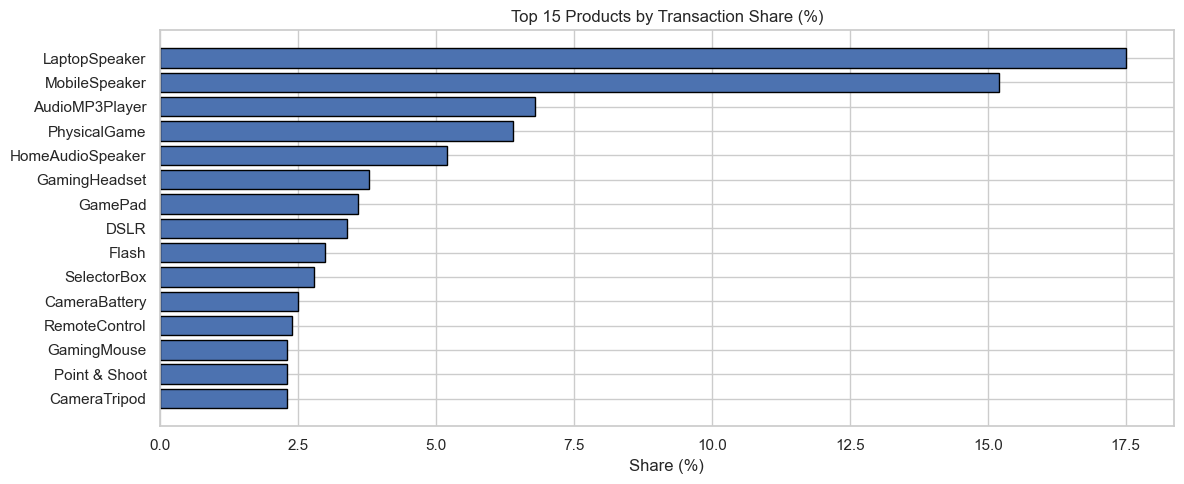

In [26]:
products = pd.read_csv(data_dir / "ProductList.csv")
print(f"Shape: {products.shape}")
print(f"Total products: {len(products) - 1}")  # minus Total row

# Top 15 products by frequency
top_products = (
    products[products["Product"] != "Total"]
    .sort_values("Percent", ascending=False)
    .head(15)
)

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(top_products["Product"], top_products["Percent"], edgecolor="black")
ax.set_title("Top 15 Products by Transaction Share (%)")
ax.set_xlabel("Share (%)")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
## 8. Cross-File Validation

Verify consistency between files and understand how they relate to each other.

In [27]:
# Compare monthly GMV: firstfile vs Secondfile vs Sales.csv
compare = pd.DataFrame(
    {
        "Secondfile_gmv": df.set_index("Date")["total_gmv"],
    }
)
compare.index = compare.index.to_period("M")

daily_agg = daily.groupby(daily["Date"].dt.to_period("M"))["gmv_new"].sum()
compare["firstfile_gmv"] = daily_agg

sales_agg = sales_raw.groupby(sales_raw["Date"].dt.to_period("M"))["GMV"].sum()
compare["Sales_gmv"] = sales_agg

compare["first_vs_second_diff_%"] = (
    (compare["firstfile_gmv"] - compare["Secondfile_gmv"])
    / compare["Secondfile_gmv"]
    * 100
).round(2)

print("Monthly GMV comparison across files:")
compare

Monthly GMV comparison across files:


,Secondfile_gmv,firstfile_gmv,Sales_gmv,first_vs_second_diff_%
Date,,,,
2015-07,1.769372e+08,1.657196e+08,7.535963e+07,-6.34
2015-08,4.191960e+05,4.017390e+05,6.005747e+07,-4.16
2015-09,4.264885e+08,3.966427e+08,6.731766e+07,-7.00
2015-10,5.095323e+08,4.887094e+08,4.612227e+08,-4.09
2015-11,3.344877e+08,3.172484e+08,1.586880e+08,-5.15
2015-12,4.361366e+08,4.238140e+08,3.013205e+08,-2.83
2016-01,3.872102e+08,3.778607e+08,3.107457e+08,-2.41
2016-02,3.322547e+08,3.214803e+08,2.423001e+08,-3.24
2016-03,4.042102e+08,3.890068e+08,2.448412e+08,-3.76


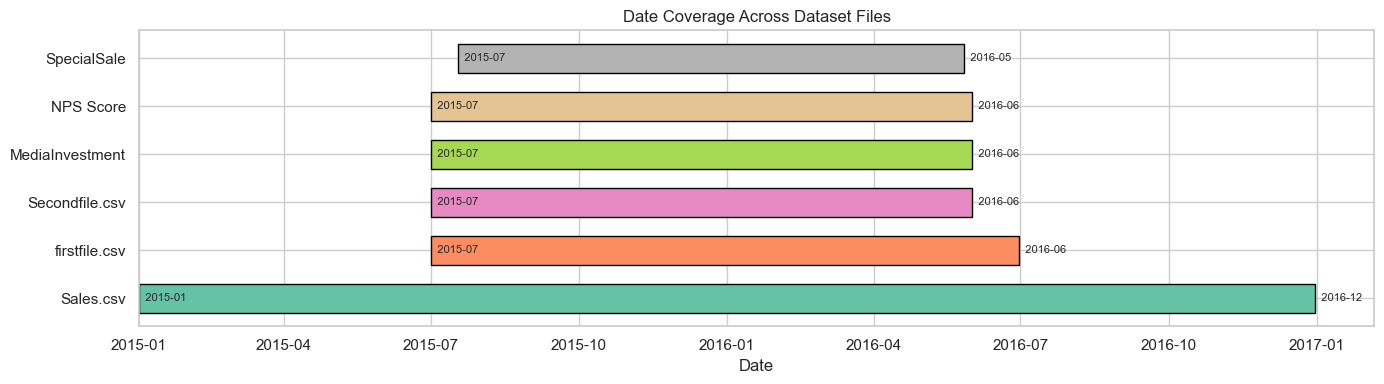

In [28]:
# Date coverage visualization
fig, ax = plt.subplots(figsize=(14, 4))

files_dates = {
    "Sales.csv": (pd.Timestamp("2015-01-01"), pd.Timestamp("2016-12-31")),
    "firstfile.csv": (pd.Timestamp("2015-07-01"), pd.Timestamp("2016-06-30")),
    "Secondfile.csv": (pd.Timestamp("2015-07-01"), pd.Timestamp("2016-06-01")),
    "MediaInvestment": (pd.Timestamp("2015-07-01"), pd.Timestamp("2016-06-01")),
    "NPS Score": (pd.Timestamp("2015-07-01"), pd.Timestamp("2016-06-01")),
    "SpecialSale": (pd.Timestamp("2015-07-18"), pd.Timestamp("2016-05-27")),
}

colors = plt.cm.Set2(np.linspace(0, 1, len(files_dates)))
for i, (name, (start, end)) in enumerate(files_dates.items()):
    ax.barh(
        i,
        (end - start).days,
        left=start,
        height=0.6,
        color=colors[i],
        edgecolor="black",
    )
    ax.text(start, i, f"  {start.strftime('%Y-%m')}", va="center", fontsize=8)
    ax.text(end, i, f"  {end.strftime('%Y-%m')}", va="center", fontsize=8)

ax.set_yticks(range(len(files_dates)))
ax.set_yticklabels(files_dates.keys())
ax.set_title("Date Coverage Across Dataset Files")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

---
## 9. Target Variable & Media Channels Deep Dive

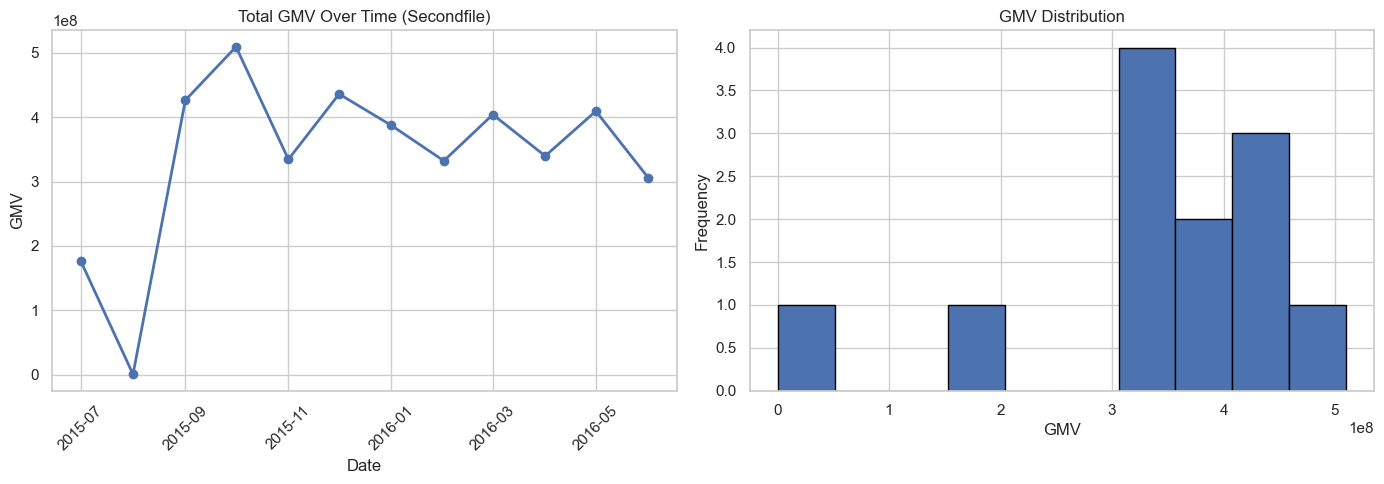

In [29]:
# Total GMV over time with trend
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(df["Date"], df["total_gmv"], marker="o", linewidth=2)
axes[0].set_title("Total GMV Over Time (Secondfile)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("GMV")
axes[0].tick_params(axis="x", rotation=45)

axes[1].hist(df["total_gmv"], bins=10, edgecolor="black")
axes[1].set_title("GMV Distribution")
axes[1].set_xlabel("GMV")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

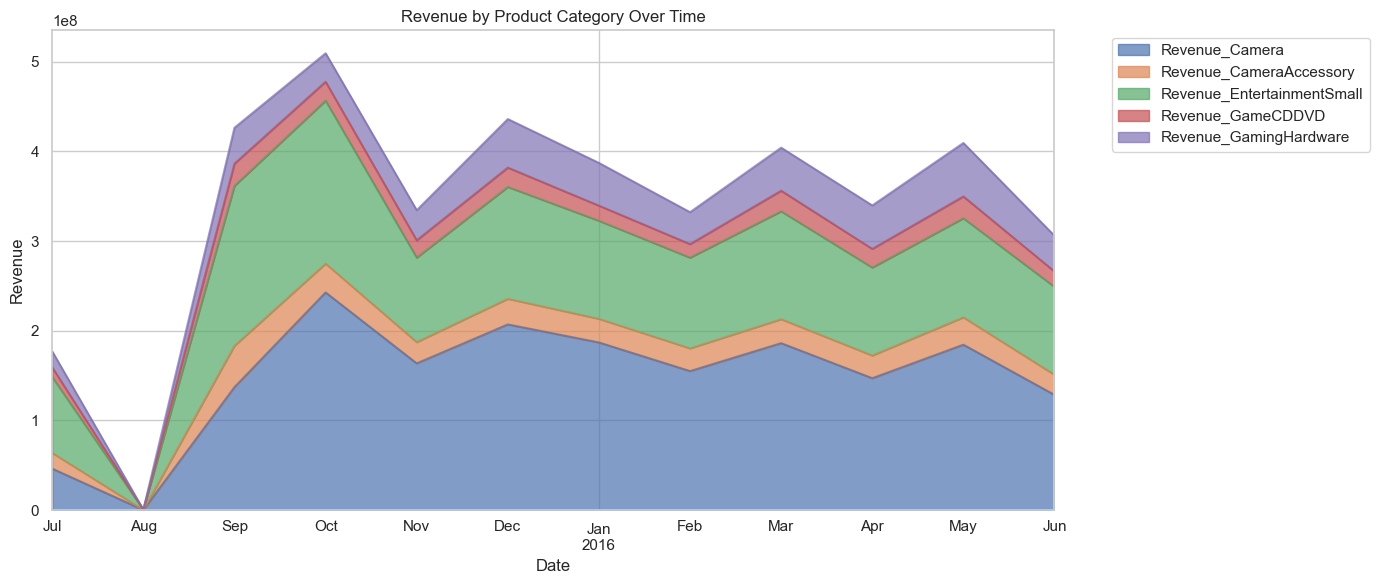

In [30]:
# Revenue by product category
fig, ax = plt.subplots(figsize=(14, 6))
df.set_index("Date")[revenue_cols].plot.area(ax=ax, alpha=0.7)
ax.set_title("Revenue by Product Category Over Time")
ax.set_ylabel("Revenue")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [31]:
# Media channels — missing values and availability
available_media = [c for c in media_cols if c in df.columns]
print("Missing values per media channel:")
print(df[available_media].isna().sum())
print(f"\nRadio: only {df['Radio'].notna().sum()}/12 months have data")
print(f"Other: only {df['Other'].notna().sum()}/12 months have data")
print("\n=> Radio and Other should be DROPPED for modeling (too sparse)")

Missing values per media channel:
TV                   0
Digital              0
Sponsorship          0
Content.Marketing    0
Online.marketing     0
Affiliates           0
SEM                  0
Radio                9
Other                9
dtype: int64

Radio: only 3/12 months have data
Other: only 3/12 months have data

=> Radio and Other should be DROPPED for modeling (too sparse)


Usable media channels (7): ['TV', 'Digital', 'Sponsorship', 'Content.Marketing', 'Online.marketing', 'Affiliates', 'SEM']


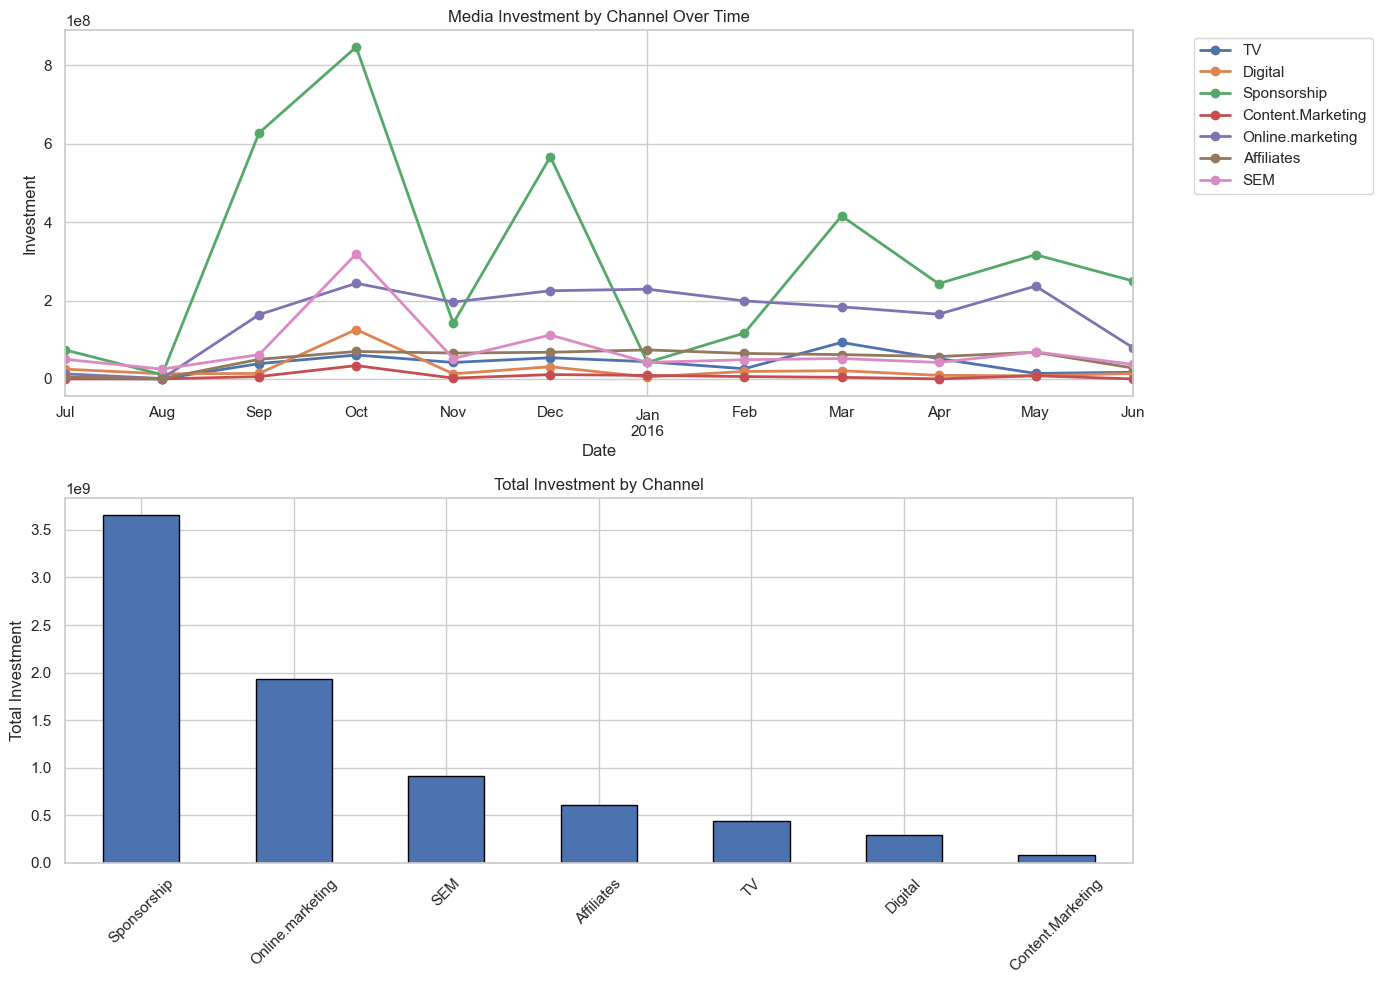

In [32]:
# Usable media channels (excluding Radio and Other)
usable_media = [c for c in available_media if c not in ["Radio", "Other"]]
print(f"Usable media channels ({len(usable_media)}): {usable_media}")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series
df.set_index("Date")[usable_media].plot(ax=axes[0], marker="o", linewidth=2)
axes[0].set_title("Media Investment by Channel Over Time")
axes[0].set_ylabel("Investment")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Share
totals = df[usable_media].sum().sort_values(ascending=False)
totals.plot.bar(ax=axes[1], edgecolor="black")
axes[1].set_title("Total Investment by Channel")
axes[1].set_ylabel("Total Investment")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

---
## 10. Correlation Analysis

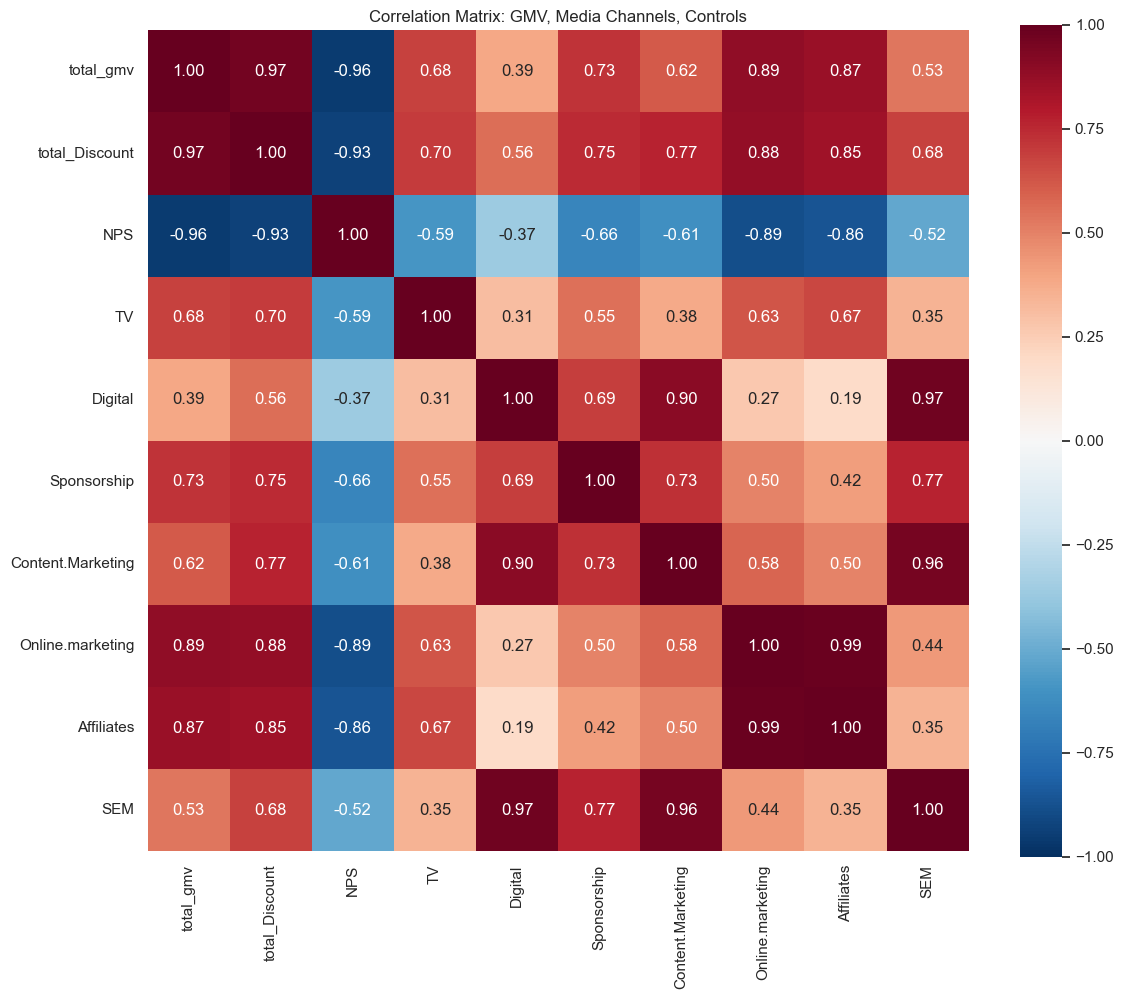

In [33]:
# Full correlation matrix: GMV vs media, NPS, discounts
corr_cols = ["total_gmv", "total_Discount", "NPS"] + usable_media
corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_title("Correlation Matrix: GMV, Media Channels, Controls")
plt.tight_layout()
plt.show()

In [34]:
# Correlation with target, sorted
print("Correlation with total_gmv (sorted):")
print(corr_matrix["total_gmv"].sort_values(ascending=False))

Correlation with total_gmv (sorted):
total_gmv            1.000000
total_Discount       0.968730
Online.marketing     0.886979
Affiliates           0.865776
Sponsorship          0.725936
TV                   0.682908
Content.Marketing    0.616916
SEM                  0.534763
Digital              0.390474
NPS                 -0.959623
Name: total_gmv, dtype: float64


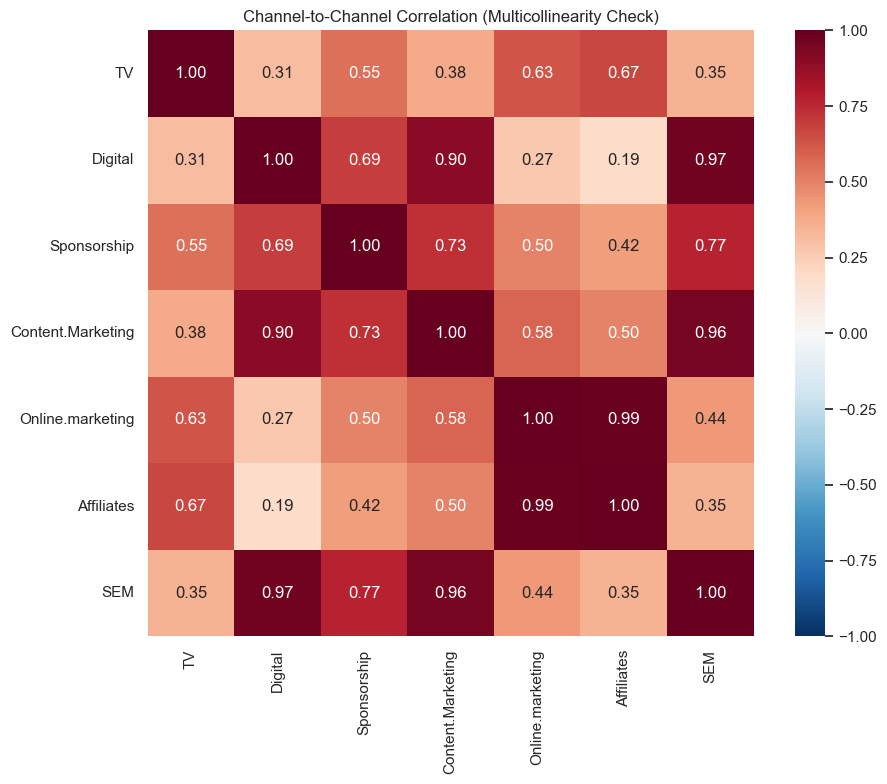


High correlations (|r| > 0.7) between channels:
  Digital <-> Content.Marketing: 0.900
  Digital <-> SEM: 0.973
  Sponsorship <-> Content.Marketing: 0.734
  Sponsorship <-> SEM: 0.771
  Content.Marketing <-> SEM: 0.958
  Online.marketing <-> Affiliates: 0.989


In [35]:
# Multicollinearity: channel-to-channel correlation
channel_corr = df[usable_media].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    channel_corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_title("Channel-to-Channel Correlation (Multicollinearity Check)")
plt.tight_layout()
plt.show()

# Flag high correlations
print("\nHigh correlations (|r| > 0.7) between channels:")
for i in range(len(usable_media)):
    for j in range(i + 1, len(usable_media)):
        r = channel_corr.iloc[i, j]
        if abs(r) > 0.7:
            print(f"  {usable_media[i]} <-> {usable_media[j]}: {r:.3f}")

---
## 11. GMV vs NPS vs Discounts vs Media

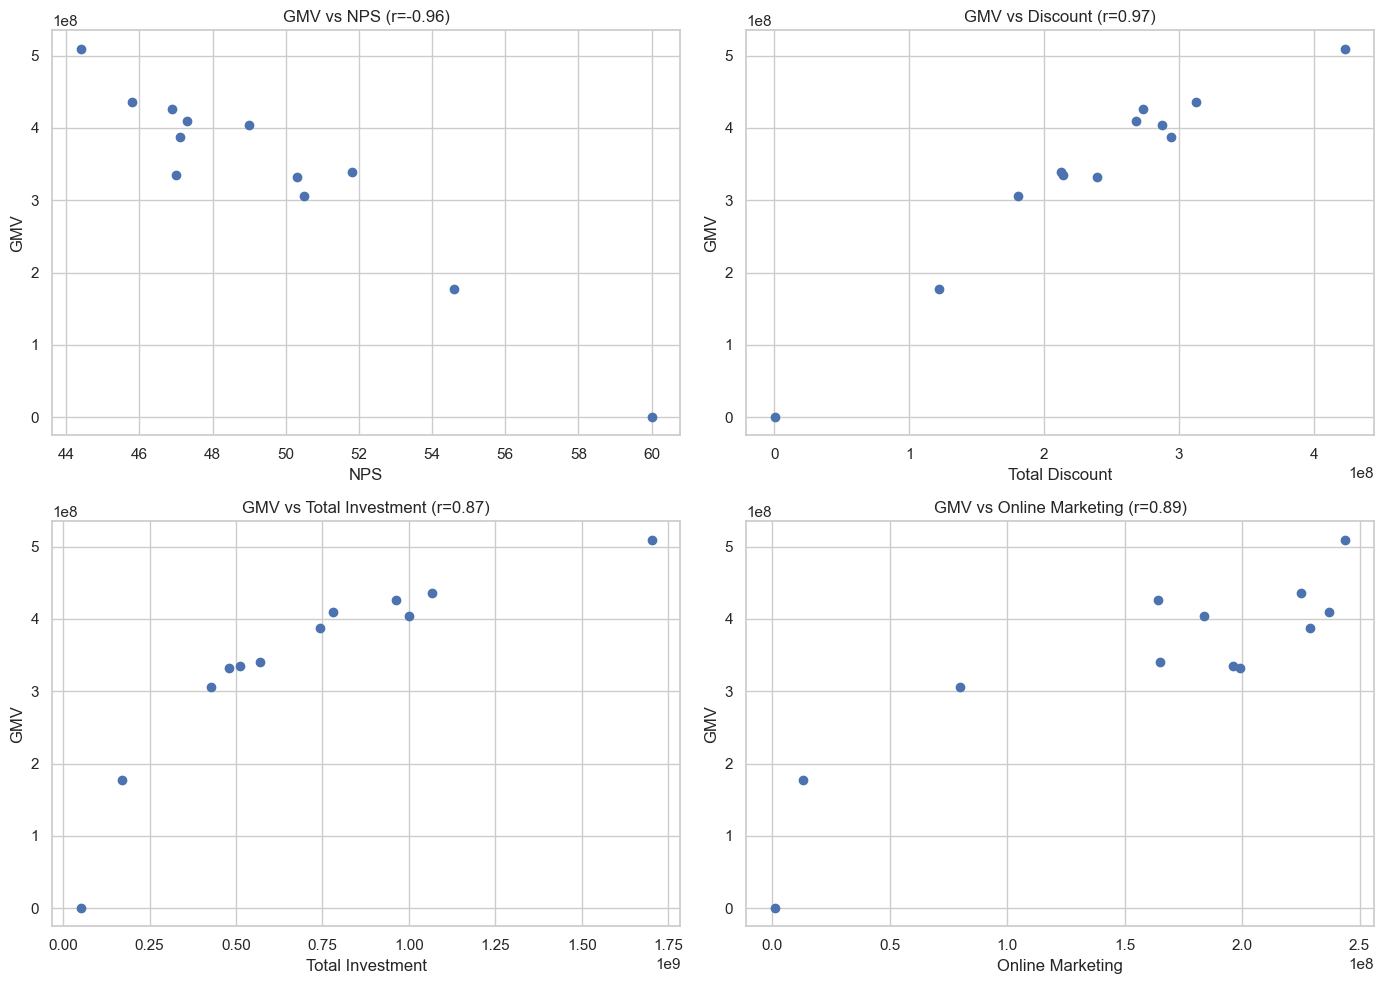

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# GMV vs NPS
axes[0, 0].scatter(df["NPS"], df["total_gmv"])
axes[0, 0].set_xlabel("NPS")
axes[0, 0].set_ylabel("GMV")
axes[0, 0].set_title(f"GMV vs NPS (r={df['NPS'].corr(df['total_gmv']):.2f})")

# GMV vs Total Discount
axes[0, 1].scatter(df["total_Discount"], df["total_gmv"])
axes[0, 1].set_xlabel("Total Discount")
axes[0, 1].set_ylabel("GMV")
axes[0, 1].set_title(
    f"GMV vs Discount (r={df['total_Discount'].corr(df['total_gmv']):.2f})"
)

# GMV vs Total Investment
axes[1, 0].scatter(df["Total.Investment"], df["total_gmv"])
axes[1, 0].set_xlabel("Total Investment")
axes[1, 0].set_ylabel("GMV")
axes[1, 0].set_title(
    f"GMV vs Total Investment (r={df['Total.Investment'].corr(df['total_gmv']):.2f})"
)

# GMV vs Online Marketing (highest channel correlation)
axes[1, 1].scatter(df["Online.marketing"], df["total_gmv"])
axes[1, 1].set_xlabel("Online Marketing")
axes[1, 1].set_ylabel("GMV")
axes[1, 1].set_title(
    f"GMV vs Online Marketing (r={df['Online.marketing'].corr(df['total_gmv']):.2f})"
)

plt.tight_layout()
plt.show()

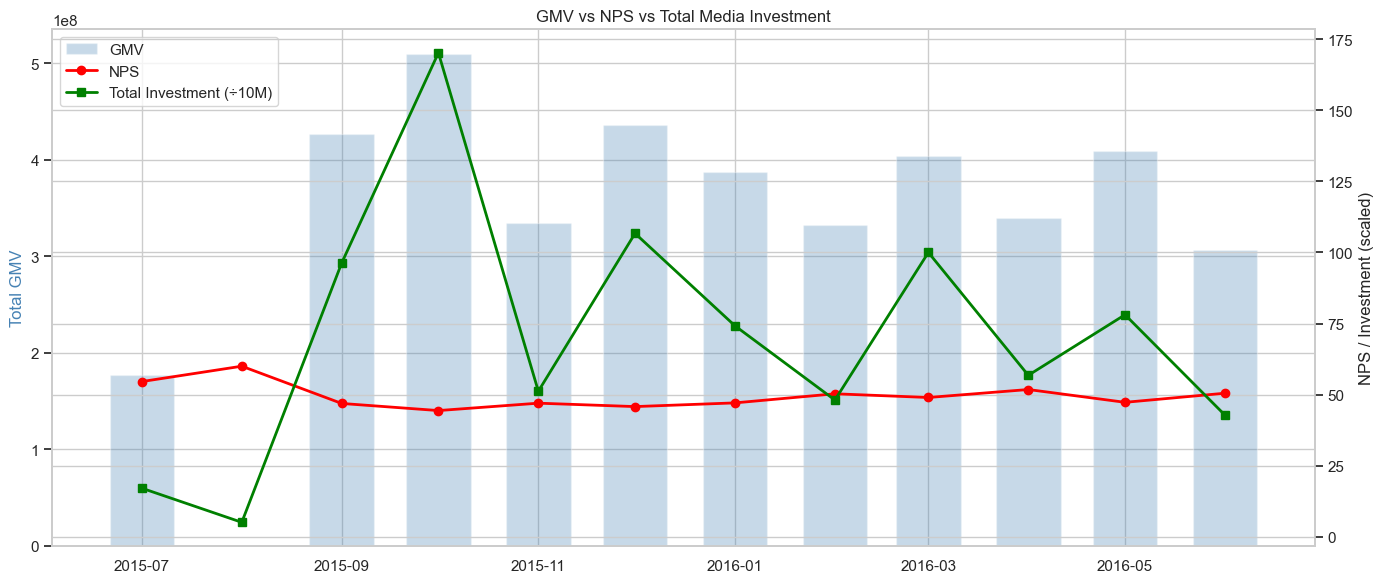

In [37]:
# Combined time series: GMV + NPS + Total Investment
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(
    df["Date"], df["total_gmv"], width=20, alpha=0.3, color="steelblue", label="GMV"
)
ax1.set_ylabel("Total GMV", color="steelblue")

ax2 = ax1.twinx()
ax2.plot(df["Date"], df["NPS"], color="red", marker="o", linewidth=2, label="NPS")
ax2.plot(
    df["Date"],
    df["Total.Investment"] / 1e7,
    color="green",
    marker="s",
    linewidth=2,
    label="Total Investment (÷10M)",
)
ax2.set_ylabel("NPS / Investment (scaled)")

ax1.set_title("GMV vs NPS vs Total Media Investment")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
plt.tight_layout()
plt.show()

---
## 12. Summary & Key Findings

### Data Landscape
- **Sales.csv** has 24 months of raw transactions (Jan 2015 – Dec 2016), but only 12 months overlap with media data
- **firstfile.csv** has daily granularity for Jul 2015 – Jun 2016 (~1.6M rows)
- **Secondfile.csv** is the pre-built MMM dataset: monthly GMV + media spend + NPS for 12 months
- **MediaInvestment.csv** confirms the channel spend data (appears to be in Crores)
- **SpecialSale.csv** has 44 sale event days across 12 promotions (useful control variable)
- All supporting files (NPS, Media, Sales events) cover **Jul 2015 – Jun 2016**

### For MMM Modeling
- **Target:** `total_gmv` from Secondfile.csv (12 monthly observations)
- **Usable channels (7):** TV, Digital, Sponsorship, Content.Marketing, Online.marketing, Affiliates, SEM
- **Drop:** Radio (9/12 NaN), Other (9/12 NaN)
- **Controls:** NPS, total_Discount, sale event days per month
- **Strongest channel correlations with GMV:** Online.marketing (0.89), Affiliates (0.87), Sponsorship (0.73)
- **Watch for multicollinearity:** check pairs with |r| > 0.7
- **NPS is negatively correlated** with GMV (-0.96) — higher sales months had lower NPS (likely due to scale/service strain during peak periods)

### Limitations
- Only **12 data points** for the MMM — strong priors will be essential
- Media data constrains us to Jul 2015 – Jun 2016 even though Sales.csv extends further
- With 7 channels + controls, we have more parameters than observations — regularization via Bayesian priors is critical